In [13]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy as sc
from skimage import transform

In [14]:
from os import listdir
from os.path import isfile, join
path1 = 'data/symptoms_new/'
path2 = 'data/nosymptoms_new/'
file_pos = [path1+f for f in listdir(path1) if isfile(join(path1, f)) and f[-4:] == 'jpeg']
file_neg = [path2+f for f in listdir(path2) if isfile(join(path2, f)) and f[-4:] == 'jpeg']

In [15]:
len(file_pos), len(file_neg)

(595, 1468)

In [24]:
import pandas as pd
file1 = pd.DataFrame()
file1['location'] = file_pos
file1['label'] = 1

file2 = pd.DataFrame()
file2['location'] = file_neg
file2['label'] = 0
file = pd.concat([file1, file2], axis=0)
file = file.sample(frac=1)

In [26]:
file_names = file.location
data = []
for file in file_names:
    img = sc.ndimage.imread(file)
    image = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    data.append(image)
data = np.array(data)

In [32]:
#normalize
data = data/255

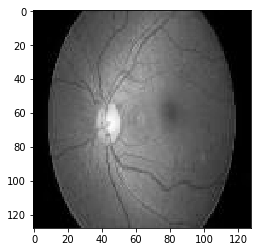

In [33]:
img = data[2]
plt.imshow(img, cmap='Greys_r')

In [34]:
data.shape

(2063, 128, 128)

In [35]:
inputs_ = tf.placeholder(tf.float32, (None, 128, 128, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 128, 128, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
conv2 = tf.layers.conv2d(maxpool1, 64, (5,5), padding='same', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
conv3 = tf.layers.conv2d(maxpool2, 128, (5,5), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (32,32))
conv4 = tf.layers.conv2d(upsample1, 128, (5,5), padding='same', activation=tf.nn.relu)
upsample2 = tf.image.resize_nearest_neighbor(conv4, (64,64))
conv5 = tf.layers.conv2d(upsample2, 64, (5,5), padding='same', activation=tf.nn.relu)
upsample3 = tf.image.resize_nearest_neighbor(conv5, (128,128))
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [36]:
sess = tf.Session()